In [1]:
import matplotlib.pylab as pl
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy.linalg as la
import pickle
import random
import time

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


### Problem 2 A Normalize Data
    Please refer to normalize_data.py.

In [2]:
X, Y = pickle.load(open('normalized_data', 'rb'))
N, D = X.shape
X_mean, X_std, Y_mean, Y_std = pickle.load(open('statistics', 'rb'))

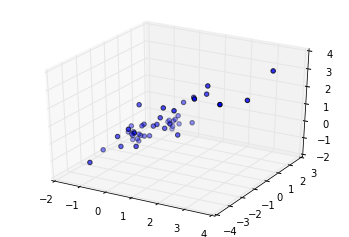

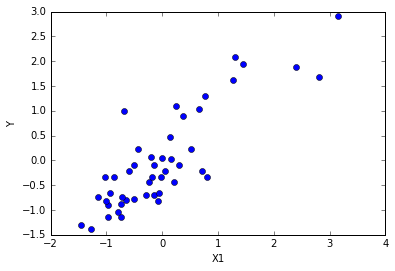

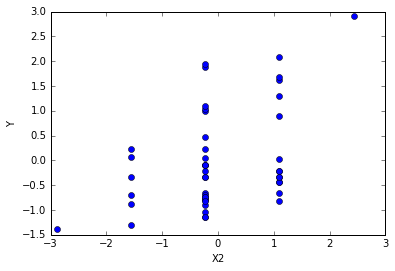

In [3]:
# plot normalized data
figure = pl.figure()
axis = figure.gca(projection='3d')
axis.scatter(X[:, 0], X[:, 1], Y)
pl.figure()
pl.plot(X[:, 0], Y, 'bo')
pl.xlabel('X1')
pl.ylabel('Y')
pl.figure()
pl.plot(X[:, 1], Y, 'bo')
pl.xlabel('X2')
pl.ylabel('Y')

### Problem 2 B Gradient Descent

In [4]:
def predict(W, bias, X):
    return np.dot(X, W) + bias
def forward(W, bias, X, Y):
    # calculate MSE and cache necessary intermediates for gradient calculation
    predictions = predict(W, bias, X)
    difference = predictions - Y
    loss = 0.5 * np.mean(difference ** 2, axis=0)
    cache = (difference,)
    return loss, cache
def backward(W, bias, X, Y, cache):
    # calculate gradients
    difference, = cache
    dW = np.mean(X * difference, axis=0).reshape(W.shape)
    dbias = np.mean(difference)
    return dW, dbias

In [5]:
def batches(data, batch_size, cyclic=False, shuffle=False):
    # generator that iterate through data
    n_batches = len(data) // batch_size
    i = 0
    if shuffle:
        indices = list(range(n_batches))
        random.shuffle(indices)
    else: indices = range(n_batches)
    while True:
        index = indices[i]
        yield data[index * batch_size : (index + 1) * batch_size]
        if cyclic: i = (i + 1) % n_batches
        else:
            if i + 1 == n_batches: return
            else: i += 1

In [6]:
def train(W, bias, X, Y, batch_size, lr, n_iterations, logging_interval=None):
    X_batches, Y_batches = batches(X, batch_size, cyclic=True), batches(Y, batch_size, cyclic=True)
    loss_history = []
    for iteration in range(n_iterations):
        X_batch, Y_batch = next(X_batches), next(Y_batches)
        loss, cache = forward(W, bias, X_batch, Y_batch)
        dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
        W -= lr * dW
        bias -= lr * dbias
        if logging_interval is not None and (iteration + 1) % logging_interval == 0:
            print('iteration %d loss %f' % (iteration + 1, loss))
        loss_history.append(loss)
    return loss_history

learning rate 0.010000 W0 -0.000000 W1 0.437012 W2 0.158175
learning rate 0.100000 W0 -0.000000 W1 0.871952 W2 -0.040366
learning rate 0.300000 W0 -0.000000 W1 0.884760 W2 -0.053173
learning rate 0.050000 W0 -0.000000 W1 0.805035 W2 0.025298
learning rate 0.500000 W0 -0.000000 W1 0.884766 W2 -0.053179
learning rate 1.500000 W0 -0.000003 W1 -6109225263.965429 W2 -6109225264.903373


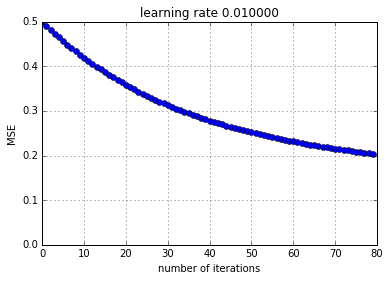

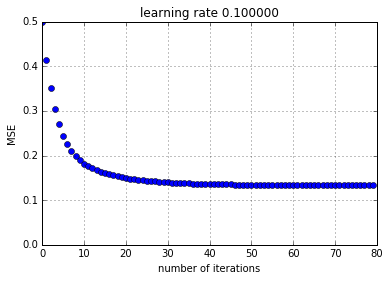

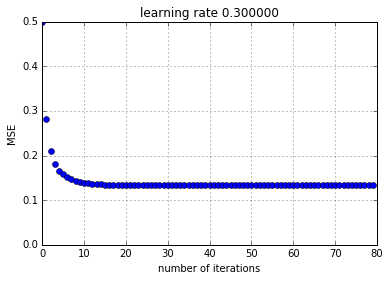

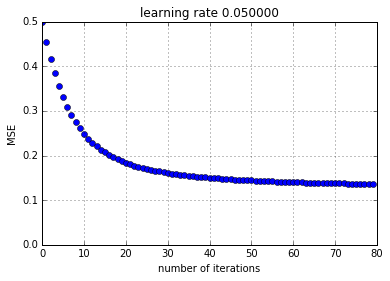

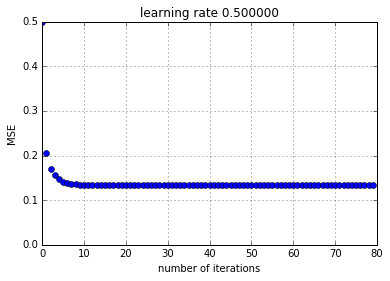

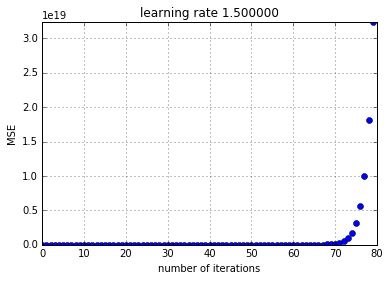

In [16]:
loss_histories = {}
predicted_prices = []
batch_size = N
n_iterations = 80
for lr in (0.01, 0.1, 0.3) + (0.05, 0.5, 1.5):
    W = np.zeros((2, 1))
    bias = np.zeros(1)
    loss_history = train(W, bias, X, Y, N, lr, n_iterations, None)
    pl.figure()
    pl.plot(range(n_iterations), loss_history, 'bo')
    pl.title('learning rate %f' % lr)
    pl.xlabel('number of iterations')
    pl.ylabel('MSE')
    pl.ylim(0, max(loss_history))
    pl.grid()
    print('learning rate %f W0 %f W1 %f W2 %f' % (lr, bias, W[0][0], W[1][0]))
    test_data = np.array([[1650, 3]])
    test_data = (test_data - X_mean) / X_std
    predicted_prices.append(float(predict(W, bias, test_data) * Y_std + Y_mean))
    loss_histories['gradient descent lr=%3f' % lr] = loss_history

### Problem 2 C Predicting Price

In [17]:
print(sum(predicted_prices) / len(predicted_prices))

84658670490040.02


### Problem 2 D Stochastic Gradient Descent

In [9]:
# implement the training strategy detailed in Problem 2 D
loss_history = []
epoch_loss_history = []
W = np.zeros((2, 1))
bias = np.zeros(1)
batch_size = 1
lr = 0.1
X_batches, Y_batches = batches(X, batch_size, cyclic=False), batches(Y, batch_size, cyclic=False)
for X_batch, Y_batch in zip(X_batches, Y_batches):
    loss, cache = forward(W, bias, X_batch, Y_batch)
    dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
    W -= lr * dW
    bias -= lr * dbias
    epoch_loss_history.append(loss)
loss_history.extend(epoch_loss_history)
epoch_loss = sum(epoch_loss_history) / len(epoch_loss_history)
print('epoch 1 loss %f' % epoch_loss)
print('epoch 1 W0 %f W1 %f W2 %f' % (bias, W[0][0], W[1][0]))
for epoch in range(2, 11):
    X_batches = batches(X, batch_size, cyclic=False, shuffle=True)
    Y_batches = batches(Y, batch_size, cyclic=False, shuffle=True)
    epoch_loss_history = []
    for X_batch, Y_batch in zip(X_batches, Y_batches):
        loss, cache = forward(W, bias, X_batch, Y_batch)
        dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
        W -= lr * dW
        bias -= lr * dbias
        epoch_loss_history.append(loss)
    loss_history.extend(epoch_loss_history)
    epoch_loss = sum(epoch_loss_history) / len(epoch_loss_history)
    print('epoch %d loss %f' % (epoch, loss))
    print('epoch %d W0 %f W1 %f W2 %f' % (epoch, bias, W[0][0], W[1][0]))
loss_histories['sgd lr=%f' % lr] = loss_history

epoch 1 loss 0.224772
epoch 1 W0 -0.149622 W1 0.639100 W2 -0.075501
epoch 2 loss 2.293469
epoch 2 W0 -0.075627 W1 -0.444241 W2 -0.084654
epoch 3 loss 0.602272
epoch 3 W0 -0.111660 W1 0.379856 W2 0.272152
epoch 4 loss 0.305105
epoch 4 W0 -0.332324 W1 0.189444 W2 0.124987
epoch 5 loss 0.069518
epoch 5 W0 -0.127769 W1 0.543314 W2 -0.260384
epoch 6 loss 0.020493
epoch 6 W0 0.445875 W1 0.366956 W2 0.103759
epoch 7 loss 0.305243
epoch 7 W0 -0.047144 W1 0.133058 W2 -0.192937
epoch 8 loss 0.493971
epoch 8 W0 0.343033 W1 0.144040 W2 -0.073300
epoch 9 loss 0.000103
epoch 9 W0 -0.176326 W1 -0.190231 W2 -0.312548
epoch 10 loss 0.025217
epoch 10 W0 -0.119118 W1 -0.170995 W2 -0.406101


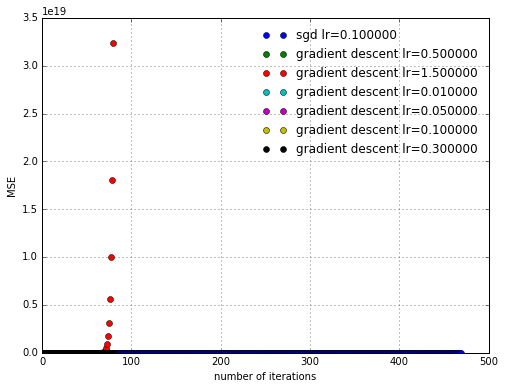

In [10]:
pl.figure(figsize=(8, 6))
for description, loss_history in loss_histories.items():
#     pl.plot(range(80), loss_history[:80], 'o', label=description)
    pl.plot(range(len(loss_history)), loss_history, 'o', label=description)
pl.xlabel('number of iterations')
pl.ylabel('MSE')
pl.legend(framealpha=0, loc='best')
pl.grid()

In [11]:
# test the result of stochastic gradient descent
test_data = np.array([[1650, 3]])
test_data = (test_data - X_mean) / X_std
float(predict(W, bias, test_data) * Y_std + Y_mean)

346470.4237208479

### Comment on model trained by SGD
    SGD may or may not lead to more accurate models compared to normal gradient descent depending on the randomness of shuffling and the choice of learning rate.

### Comment concerning computation time
    It depends on the randomness of shuffling and the choice of learning rate.